# Eviction Forecasting

In [1]:
import pandas as pd
import geopandas as gpd
import networkx as nx
from shapely.geometry import Point
from shapely.wkt import loads
from scipy.spatial import distance_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

/Users/gauravsett/Documents/GitHub/sf-eviction-forecasting/env/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Data Processing

In [2]:
def load_parcels():
    df_p = (
        pd.read_csv("data/parcels.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["the_geom"])
    )#.sample(10_000)
    df_p["geometry"] = df_p["the_geom"].apply(loads)
    df_p = gpd.GeoDataFrame(df_p, geometry="geometry")
    return df_p

df_p = load_parcels()
df_p

/Users/gauravsett/Documents/GitHub/sf-eviction-forecasting/env/lib/python3.7/site-packages/ipykernel_launcher.py:11: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  # This is added back by InteractiveShellApp.init_path()


,closed_roll_year,property_location,parcel_number,block,lot,volume_number,use_code,use_definition,property_class_code,property_class_code_definition,...,current_supervisor_districts_2,analysis_neighborhoods_2,delete_-_supervisor_districts_2,delete_-_fire_prevention_districts_2,delete_-_current_police_districts_2,delete_-_zip_codes_2,delete_-_neighborhoods_2,delete_-_police_districts_2,neighborhoods,geometry
95,2011,0000 0000VBANCROFT AV0000,4867021,4867,021,29,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,POINT (-122.36766 37.71103)
96,2011,0000 0000 V 0000,4957017,4957,017,30,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,POINT (-122.37720 37.71078)
97,2011,0000 0000 V 0000,4950003,4950,003,30,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,POINT (-122.37746 37.71162)
98,2011,0000 0000VCARROLL AV0000,4867012,4867,012,29,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,POINT (-122.36842 37.71113)
99,2007,0000 0000 V 0000,4890002,4890,002,30,MISC,Miscellaneous/Mixed-Use,V,Vacant Lot,...,NaN,NaN,NaN,NaN,NaN,58.0,NaN,NaN,NaN,POINT (-122.37511 37.71423)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2666112,2019,0000 0423 RALSTON ST0000,6996017,6996,017,41,SRES,Single Family Residential,D,Dwelling,...,1.0,24.0,6.0,9.0,5.0,64.0,24.0,8.0,64.0,POINT (-122.46923 37.72012)
2666113,2019,0000 0137 SAINT CHARLES AV0000,7130015,7130,015,43,SRES,Single Family Residential,D,Dwelling,...,8.0,24.0,4.0,9.0,5.0,64.0,24.0,8.0,65.0,POINT (-122.46904 37.71153)
2666114,2019,0000 0115 LAKE MERCED HL0000,7381054,7381,054,44,SRES,Single Family Residential,Z,Condominium,...,8.0,16.0,4.0,1.0,5.0,64.0,14.0,8.0,43.0,POINT (-122.48352 37.70956)
2666115,2019,0000 0002 BEACHMONT DR0000,7221017,7221,017,44,SRES,Single Family Residential,D,Dwelling,...,8.0,41.0,4.0,1.0,5.0,64.0,40.0,8.0,62.0,POINT (-122.47385 37.73442)


In [3]:
def load_evictions():
    df_e = (
        pd.read_csv("data/evictions.csv")
        .rename(columns=lambda x: x.strip().lower().replace(" ", "_"))
        .dropna(subset=["shape"])
    )
    df_e["geometry"] = df_e["shape"].apply(loads)
    df_e["year"] = pd.to_datetime(df_e["file_date"]).dt.year.astype(int)
    df_e = gpd.GeoDataFrame(df_e, geometry="geometry")
    return df_e

df_e = load_evictions()
df_e

,eviction_id,address,city,state,eviction_notice_source_zipcode,file_date,non_payment,breach,nuisance,illegal_use,...,delete_-_fire_prevention_districts,delete_-_zip_codes,"cbd,_bid_and_gbd_boundaries_as_of_2017",central_market/tenderloin_boundary,"areas_of_vulnerability,_2016",central_market/tenderloin_boundary_polygon_-_updated,fix_it_zones_as_of_2018-02-07,neighborhoods,geometry,year
0,M222138,400 Block Of Eddy Street,San Francisco,CA,94102.0,12/12/2022,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.0,POINT (-122.41508 37.78363),2022
1,M211838,900 Block Of Bush Street,San Francisco,CA,94109.0,12/06/2021,False,False,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.0,POINT (-122.41292 37.78964),2021
2,M222033,1000 Block Of Pine Street,San Francisco,CA,94109.0,11/14/2022,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,POINT (-122.41310 37.79057),2022
3,M221840,100 Block Of Caine Avenue,San Francisco,CA,94117.0,10/18/2022,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.0,POINT (-122.45181 37.71578),2022
4,M120930,1900 Block Of Jefferson Street,San Francisco,CA,94133.0,06/21/2012,False,True,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,POINT (-122.44464 37.80454),2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177573,M2K0482,2600 Block Of 36th Avenue,San Francisco,CA,94116.0,03/24/2000,False,False,False,False,...,1.0,29491.0,NaN,NaN,1.0,NaN,NaN,40.0,POINT (-122.49361 37.73761),2000
177574,S000563,3500 Block Of Sacramento Street,San Francisco,CA,94118.0,10/16/1997,False,False,False,False,...,11.0,54.0,NaN,NaN,1.0,NaN,NaN,10.0,POINT (-122.45113 37.78766),1997
177575,S000649,1100 Block Of Chestnut Street,San Francisco,CA,NaN,10/27/1997,False,False,False,False,...,5.0,28858.0,NaN,NaN,1.0,NaN,NaN,107.0,POINT (-122.42224 37.80260),1997
177576,E991319,2100 Block Of Sacramento Street,San Francisco,CA,94115.0,07/12/1999,False,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.0,POINT (-122.42828 37.79057),1999


In [4]:
def create_blocks(df_p):
    df_b = (
        df_p.loc[df_p["closed_roll_year"] == df_p["closed_roll_year"].max()]
        [["geometry", "block"]]
        .dropna()
        .drop_duplicates()
        .groupby("block")
        ["geometry"]
        .apply(lambda x: x.unary_union)
        .apply(lambda x: x.centroid)
        .reset_index()
    )
    return df_b

df_b = create_blocks(df_p)
df_b

,block,geometry
0,0001,POINT (-122.42156 37.80866)
1,0002,POINT (-122.42050 37.80873)
2,0004,POINT (-122.41508 37.80851)
3,0005,POINT (-122.41668 37.80840)
4,0006,POINT (-122.41835 37.80832)
...,...,...
5397,8952,POINT (-122.36696 37.80978)
5398,8953,POINT (-122.36639 37.81007)
5399,8954,POINT (-122.36544 37.81144)
5400,8958,POINT (-122.36838 37.81103)


In [5]:
def merge_blocks_parcels(df_p, df_b):
    # Merge blocks onto parcels
    df = (
        df_p.merge(df_b, on="block", how="left")
        .rename(columns={"geometry_x": "geometry"})
        .dropna(subset=["geometry"])
    )
    df = gpd.GeoDataFrame(df, geometry="geometry")
    df = gpd.sjoin_nearest(df, df_b, how="left", max_distance=0.01)
    df["current_sales_date"] = (
        pd.to_datetime(df["current_sales_date"])
        .dt.year
        .fillna(-1)
        .astype(int)
    )
    # df["year_property_built"] = df["year_property_built"].fillna(-1).astype(int)
    return df

def aggregate_parcels(df):
    # Aggregate parcels by block and year
    mode = lambda x: x.value_counts().index[0]
    def by_year(df_y):
        return df_y.groupby("block_right").agg({
            "assessed_personal_property_value": "mean",
            "assessed_land_value": "mean",
            "assessed_fixtures_value": "mean",
            "assessed_improvement_value": "mean",
            "property_area": "mean",
            "number_of_units": "sum",
            "number_of_rooms": "mean",
            "number_of_bedrooms": "mean",
            "number_of_bathrooms": "mean",
            "use_code": list,
            # "zoning_code": list,
            # "property_class_code": list,
        })
    df = (
        df.groupby("closed_roll_year")
        .apply(by_year)
        .reset_index()
        .rename(columns={"block_right": "block", "closed_roll_year": "year"})
    )
    return df

def get_dummies(df, columns):
    for column in columns:
        d = pd.get_dummies(df[column].explode()).groupby(level=0).sum()
        d.columns = [f"{column}_{c.lower()}" for c in d.columns]
        df = df.drop(columns=[column]).merge(d, left_index=True, right_index=True)
    return df

def merge_evictions_blocks(df_e, df_b, df):
    # Merge evictions onto blocks
    df_e = gpd.sjoin_nearest(df_e, df_b, how="left", max_distance=0.001)
    df_e_agg = (
        df_e.groupby(["block", "year"])
        .size()
        .reset_index()
        .rename(columns={0: "eviction_count"})
    )
    def by_year(df_y):
        df_e_year = df_e_agg.loc[df_e_agg["year"] == df_y["year"].max()]
        return df_y.merge(df_e_year, how="left", on=["block"])
    df = df.groupby("year").apply(by_year).reset_index()
    df["eviction_count"] = df["eviction_count"].fillna(0).astype(int)
    df = df.drop(columns=["level_1", "year_x", "year_y"])
    df = df.sort_values(["year", "block"])
    return df

df = merge_blocks_parcels(df_p, df_b)
df = aggregate_parcels(df)
df = get_dummies(df, ["use_code"])
df = merge_evictions_blocks(df_e, df_b, df)
df.to_parquet("data/blocks.parquet")
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,use_code_comh,use_code_comm,use_code_como,use_code_comr,use_code_govt,use_code_ind,use_code_misc,use_code_mres,use_code_sres,eviction_count
0,2007,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1,2007,0002,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2007,0004,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
3,2007,0005,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
4,2007,0006,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69400,2019,8950,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
69401,2019,8952,0.0,13134600.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
69402,2019,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0
69403,2019,8954,0.0,3090982.5,0.0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,9.0,0.0,7.0,0.0,0.0,0


## Feature Engineering

In [6]:
df = pd.read_parquet("data/blocks.parquet")

### Graph Construction

In [7]:
def build_graph(df_b):
    graph = nx.Graph()
    graph.add_nodes_from(df_b["block"])
    
    coordinates = [list(p.coords)[0] for p in df_b["geometry"]]
    matrix = distance_matrix(coordinates, coordinates)
    max_d = matrix.max()
    p = 0.02
    neighbors = np.argwhere(matrix < max_d*p)
    for i, j in tqdm(neighbors, total=len(neighbors)):
        if i < j:
            graph.add_edge(
                df_b.iloc[i]["block"], 
                df_b.iloc[j]["block"], 
                weight=matrix[i, j]
            )
    return graph

graph = build_graph(df_b)

100%|██████████| 115638/115638 [00:14<00:00, 8127.21it/s] 


In [8]:
pd.Series([graph.degree(n) for n in graph.nodes]).describe()

count    5402.000000
mean       20.406516
std         6.689773
min         0.000000
25%        16.000000
50%        20.000000
75%        25.000000
max        53.000000
dtype: float64

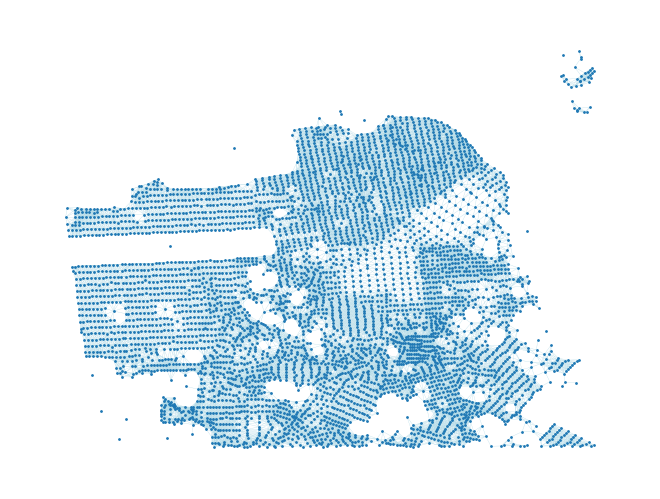

In [9]:
nx.draw(graph, pos={n: list(p.coords)[0] for n, p in df_b.set_index("block")["geometry"].items()}, edge_color="lightblue", node_size=1, width=0.2)

In [10]:
neighbors = df_b.apply(lambda x: list(graph.neighbors(x["block"])), axis=1)
neighbors

0       [0002, 0006, 0007, 0010, 0024, 0025, 0026T, 04...
1       [0001, 0006, 0007, 0010, 0011, 0023, 0024, 002...
2       [0005, 0006, 0011, 0012, 0013, 0014, 0020, 002...
3       [0004, 0006, 0007, 0010, 0011, 0012, 0013, 001...
4       [0001, 0002, 0004, 0005, 0007, 0010, 0011, 001...
                              ...                        
5397                 [8948, 8949, 8950, 8953, 8954, 8958]
5398                       [8949, 8950, 8952, 8954, 8958]
5399                                   [8952, 8953, 8958]
5400           [8947, 8948, 8949, 8950, 8952, 8953, 8954]
5401    [0202, 0203, 0231, 0232, 0233, 0234, 0235, 023...
Length: 5402, dtype: object

### Spatial Aggregation

In [11]:
features = ["assessed_personal_property_value", "assessed_land_value", "assessed_fixtures_value", "assessed_improvement_value", "property_area", "number_of_units", "number_of_rooms", "number_of_bedrooms", "number_of_bathrooms", "eviction_count"]

In [12]:
def compute_neighbor_features(df):
    def by_year(df_y):
        df_y[[f"{f}_neighbors" for f in features]] = neighbors.apply(
            lambda x: 
                df_y.loc[df_y["block"].isin(x)]
                [features]
                .mean()
        )
        return df_y
    df = df.groupby("year").apply(by_year).reset_index(drop=True)
    return df

df = compute_neighbor_features(df)
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,assessed_personal_property_value_neighbors,assessed_land_value_neighbors,assessed_fixtures_value_neighbors,assessed_improvement_value_neighbors,property_area_neighbors,number_of_units_neighbors,number_of_rooms_neighbors,number_of_bedrooms_neighbors,number_of_bathrooms_neighbors,eviction_count_neighbors
0,2007,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,9304.021887,3.252543e+06,4681.352941,1.110006e+07,54288.214977,125.200000,17.138837,0.181089,6.326737,0.800000
1,2007,0002,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,7593.621887,2.893201e+06,3920.152941,4.469393e+06,24839.814977,161.500000,13.213837,0.181089,9.626737,0.800000
2,2007,0004,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,276134.681986,7.974246e+06,240209.830703,1.344230e+07,53163.636506,94.307692,55.836275,12.038462,42.075411,0.000000
3,2007,0005,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,262914.435793,4.555037e+06,224430.099099,8.376079e+06,47555.446083,92.214286,53.055253,11.258403,39.774506,0.000000
4,2007,0006,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,262239.092867,3.896597e+06,221617.115546,6.498570e+06,34945.149050,81.357143,39.606891,11.340971,29.061960,0.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69400,2019,8950,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69401,2019,8952,0.0,13134600.0,0.0,0.0,0.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69402,2019,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69403,2019,8954,0.0,3090982.5,0.0,0.0,0.0,0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Graph Features

In [13]:
df_g = df_b.copy()

In [14]:
def compute_degree(df_g):
    df_g["degree"] = df_g["block"].apply(lambda x: graph.degree(x))
    return df_g

df_g = compute_degree(df_g)
df_g

,block,geometry,degree
0,0001,POINT (-122.42156 37.80866),10
1,0002,POINT (-122.42050 37.80873),10
2,0004,POINT (-122.41508 37.80851),13
3,0005,POINT (-122.41668 37.80840),14
4,0006,POINT (-122.41835 37.80832),14
...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6
5398,8953,POINT (-122.36639 37.81007),5
5399,8954,POINT (-122.36544 37.81144),3
5400,8958,POINT (-122.36838 37.81103),7


In [15]:
def compute_clustering(df_g):
    df_g["clustering"] = nx.clustering(graph).values()
    return df_g

df_g = compute_clustering(df_g)
df_g

,block,geometry,degree,clustering
0,0001,POINT (-122.42156 37.80866),10,0.800000
1,0002,POINT (-122.42050 37.80873),10,0.844444
2,0004,POINT (-122.41508 37.80851),13,0.743590
3,0005,POINT (-122.41668 37.80840),14,0.670330
4,0006,POINT (-122.41835 37.80832),14,0.681319
...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333
5398,8953,POINT (-122.36639 37.81007),5,0.800000
5399,8954,POINT (-122.36544 37.81144),3,1.000000
5400,8958,POINT (-122.36838 37.81103),7,0.619048


In [16]:
def compute_betweenness_centrality(df_g):
    df_g["betweenness_centrality"] = nx.betweenness_centrality(graph).values()
    return df_g

df_g = compute_betweenness_centrality(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06
...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07


In [17]:
def compute_closeness_centrality(df_g):
    df_g["closeness_centrality"] = nx.closeness_centrality(graph).values()
    return df_g

df_g = compute_closeness_centrality(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866
...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296


In [18]:
def compute_eigen_centrality(df_g):
    df_g["eigen_centrality"] = nx.eigenvector_centrality(graph).values()
    return df_g

df_g = compute_eigen_centrality(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009,3.291674e-07
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313,3.035517e-07
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642,3.794351e-07
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866,4.464551e-07
...,...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134,8.721721e-24
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008,7.524343e-24
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825,4.871874e-24
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296,9.497001e-24


In [19]:
def compute_page_rank(df_g):
    df_g["page_rank"] = nx.pagerank(graph).values()
    return df_g

df_g = compute_page_rank(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009,3.291674e-07,0.000100
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313,3.035517e-07,0.000127
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642,3.794351e-07,0.000137
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866,4.464551e-07,0.000135
...,...,...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134,8.721721e-24,0.000226
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008,7.524343e-24,0.000185
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825,4.871874e-24,0.000137
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296,9.497001e-24,0.000250


In [20]:
def compute_bridges(df_g):
    bridges = pd.DataFrame(list(nx.bridges(graph)))
    bridges = pd.concat([bridges[0], bridges[1]]).drop_duplicates().reset_index(drop=True)
    df_g["bridge"] = df_g["block"].isin(bridges).astype(int)
    return df_g

df_g = compute_bridges(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009,3.291674e-07,0.000100,0
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313,3.035517e-07,0.000127,0
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642,3.794351e-07,0.000137,0
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866,4.464551e-07,0.000135,0
...,...,...,...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134,8.721721e-24,0.000226,0
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008,7.524343e-24,0.000185,0
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825,4.871874e-24,0.000137,0
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296,9.497001e-24,0.000250,0


In [21]:
def compute_cliques(df_g):
    df_g["cliques"] = nx.node_clique_number(graph).values()
    return df_g

df_g = compute_cliques(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009,3.291674e-07,0.000100,0,8
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313,3.035517e-07,0.000127,0,8
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642,3.794351e-07,0.000137,0,8
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866,4.464551e-07,0.000135,0,8
...,...,...,...,...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134,8.721721e-24,0.000226,0,5
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825,4.871874e-24,0.000137,0,4
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296,9.497001e-24,0.000250,0,5


In [22]:
def compute_constraint(df_g):
    df_g["constraint"] = nx.constraint(graph).values()
    return df_g

df_g = compute_constraint(df_g)
df_g

,block,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques,constraint
0,0001,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
1,0002,POINT (-122.42050 37.80873),10,0.844444,2.492843e-07,0.044009,3.291674e-07,0.000100,0,8,0.207862
2,0004,POINT (-122.41508 37.80851),13,0.743590,1.340645e-05,0.043313,3.035517e-07,0.000127,0,8,0.170369
3,0005,POINT (-122.41668 37.80840),14,0.670330,1.441052e-05,0.043642,3.794351e-07,0.000137,0,8,0.157117
4,0006,POINT (-122.41835 37.80832),14,0.681319,9.709285e-06,0.043866,4.464551e-07,0.000135,0,8,0.159815
...,...,...,...,...,...,...,...,...,...,...,...
5397,8952,POINT (-122.36696 37.80978),6,0.733333,9.714708e-08,0.001134,8.721721e-24,0.000226,0,5,0.495780
5398,8953,POINT (-122.36639 37.81007),5,0.800000,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129
5399,8954,POINT (-122.36544 37.81144),3,1.000000,0.000000e+00,0.000825,4.871874e-24,0.000137,0,4,0.598433
5400,8958,POINT (-122.36838 37.81103),7,0.619048,2.457250e-07,0.001296,9.497001e-24,0.000250,0,5,0.459773


In [23]:
df = df.merge(df_g, on="block")
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,geometry,degree,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques,constraint
0,2007,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
1,2008,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
2,2009,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
3,2010,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
4,2011,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.42156 37.80866),10,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69400,2019,8935,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.36698 37.81994),14,0.736264,6.427825e-07,0.002721,3.270568e-15,0.000223,0,9,0.224378
69401,2019,8939,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.36542 37.82124),13,0.794872,3.523019e-07,0.002608,3.085459e-15,0.000195,0,9,0.247834
69402,2019,8941,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.36477 37.82179),11,0.872727,8.077448e-08,0.002276,2.641854e-15,0.000167,0,9,0.272590
69403,2019,8942,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,POINT (-122.36546 37.82272),10,0.911111,4.934455e-08,0.002235,2.414316e-15,0.000153,0,9,0.284059


In [24]:
df["latitude"] = df["geometry"].apply(lambda x: x.centroid.y)
df["longitude"] = df["geometry"].apply(lambda x: x.centroid.x)

In [25]:
df.drop(columns=["geometry"]).to_parquet("data/input.parquet")

## Model Training

### Data Preparation

In [26]:
df = pd.read_parquet("data/input.parquet")
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques,constraint,latitude,longitude
0,2007,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
1,2008,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
2,2009,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
3,2010,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
4,2011,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.800000,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69400,2019,8935,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.736264,6.427825e-07,0.002721,3.270568e-15,0.000223,0,9,0.224378,37.819943,-122.366978
69401,2019,8939,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.794872,3.523019e-07,0.002608,3.085459e-15,0.000195,0,9,0.247834,37.821243,-122.365420
69402,2019,8941,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.872727,8.077448e-08,0.002276,2.641854e-15,0.000167,0,9,0.272590,37.821786,-122.364767
69403,2019,8942,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.911111,4.934455e-08,0.002235,2.414316e-15,0.000153,0,9,0.284059,37.822718,-122.365462


In [27]:
df = df.groupby("block").filter(lambda x: len(x) == 13)
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,clustering,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques,constraint,latitude,longitude
0,2007,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
1,2008,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
2,2009,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
3,2010,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
4,2011,0001,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69308,2015,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391
69309,2016,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391
69310,2017,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391
69311,2018,8953,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,...,0.8,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391


In [191]:
features_s = features + [f"{f}_neighbors" for f in features]
features_s.remove("eviction_count")

def standardize(df):
    def by_year(df_y):
        df_y[features_s] = df_y[features_s].apply(lambda x: (x - x.mean()) / x.std())
        return df_y
    df = df.groupby("year").apply(by_year).reset_index(drop=True)
    return df

df = standardize(df)
df

,year,block,assessed_personal_property_value,assessed_land_value,assessed_fixtures_value,assessed_improvement_value,property_area,number_of_units,number_of_rooms,number_of_bedrooms,...,betweenness_centrality,closeness_centrality,eigen_centrality,page_rank,bridge,cliques,constraint,latitude,longitude,eviction_class
0,2007,0001,-0.048712,-0.153162,-0.024003,-0.125206,-0.166897,-0.545641,-0.261230,-0.192676,...,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557,0
1,2008,0001,-0.046232,-0.159991,-0.021649,-0.122726,-0.166222,-0.553154,-0.276860,-0.205879,...,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557,0
2,2009,0001,-0.047384,-0.164649,-0.021864,-0.123337,-0.166094,-0.552915,-0.276004,-0.211834,...,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557,0
3,2010,0001,-0.042477,-0.148151,-0.025017,-0.131333,-0.166129,-0.553216,-0.275555,-0.217886,...,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557,0
4,2011,0001,-0.040286,-0.151922,-0.031152,-0.122036,-0.165284,-0.549567,-0.276285,-0.206560,...,1.791900e-06,0.043991,3.264575e-07,0.000108,0,8,0.205829,37.808658,-122.421557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65541,2015,8953,-0.037954,-0.163230,-0.049016,-0.125150,-0.167493,-0.546911,-0.275101,-0.262516,...,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391,0
65542,2016,8953,-0.051212,-0.117574,-0.040260,-0.121495,-0.168727,-0.543587,-0.252143,-0.269620,...,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391,0
65543,2017,8953,-0.049836,-0.123913,-0.039962,-0.126973,-0.168812,-0.557074,-0.251719,-0.269713,...,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391,0
65544,2018,8953,-0.055477,-0.130165,-0.038428,-0.126902,-0.171961,-0.540162,-0.250239,-0.296502,...,4.571627e-08,0.001008,7.524343e-24,0.000185,0,5,0.522129,37.810069,-122.366391,0


In [192]:
feature_sets = {
    "tax": features_s,
    "graph": ["degree", "clustering", "betweenness_centrality", "closeness_centrality", "eigen_centrality", "page_rank", "bridge", "cliques", "constraint"],
    "all": df.columns.drop(["block", "year"]).tolist(),
}

In [161]:
df["eviction_class"] = df["eviction_count"].apply(lambda x: 1 if x > 0 else 0)

### Autoregressive Model

In [127]:
import sklearn
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from copy import deepcopy

In [ ]:
def train_autoregressive(data, features):
    df_x = data[features + ["year"]]
    df_y = data[["year", "eviction_count"]]
    model = xgb.XGBRegressor(
        max_depth=5, n_estimators=100, learning_rate=0.01, random_state=7, 
    )
    params = model.get_xgb_params()
    r2s = []
    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    for year in range(2007, 2019):
        x = df_x.loc[df_x["year"] == year].drop(columns=["year"]).values
        y = df_y.loc[df_y["year"] == year+1].drop(columns=["year"]).values
        r2_kf = []
        model_temp = None
        for train_index, test_index in kf.split(x):
            model_k = deepcopy(model)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if year == 2007:
                model_k.fit(x_train, y_train)
                y_pred = model_k.predict(x_test)
            else:
                d = xgb.DMatrix(x_train, label=y_train)
                model_k = xgb.train(params, d)
                y_pred = model_k.predict(xgb.DMatrix(x_test))
            r2 = sklearn.metrics.r2_score(y_test, y_pred)
            r2_kf.append(r2)
            model_temp = model_k
        model = model_temp
        r2 = np.mean(r2_kf)
        r2_std = np.std(r2_kf)
        print(f"Year {year} R2: {r2} +/- {r2_std}")
        r2s.append(r2)
    return model, r2s

model, rsmes = train_autoregressive(df, feature_sets["all"])

In [230]:
def train_autoregressive_classifier(data, features):
    df_x = data[features + ["year"]]
    df_y = data[["year", "eviction_class"]]
    model = xgb.XGBClassifier(
        max_depth=10, n_estimators=100, learning_rate=0.05, random_state=7,
    )
    params = model.get_xgb_params()
    accuracies = []
    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    for year in range(2007, 2019):
        x = df_x.loc[df_x["year"] == year].drop(columns=["year"]).values
        y = df_y.loc[df_y["year"] == year+1].drop(columns=["year"]).values
        accuracy_kf = []
        for train_index, test_index in kf.split(x):
            model_k = deepcopy(model)
            x_train, x_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]
            if year == 2007:
                model_k.fit(x_train, y_train)
                y_pred = model_k.predict(x_test)
            else:
                d = xgb.DMatrix(x_train, label=y_train)
                model_k = xgb.train(params, d)
                y_pred = model_k.predict(xgb.DMatrix(x_test))
            y_pred = np.where(y_pred > 0.5, 1, 0)
            accuracy = sklearn.metrics.accuracy_score(y_test, y_pred)
            accuracy_kf.append(accuracy)            
        model = model_k
        accuracy = np.mean(accuracy_kf)
        accuracy_std = np.std(accuracy_kf)
        print(f"Year {year} Accuracy: {accuracy} +/- {accuracy_std}")
        accuracies.append(accuracy)
    return model, accuracies

model, accuracies = train_autoregressive_classifier(df, feature_sets["all"])

Year 2007 Accuracy: 0.8698937734988281 +/- 0.008433327248602298
Year 2008 Accuracy: 0.8851627023455567 +/- 0.012474230785795482
Year 2009 Accuracy: 0.8831791652901663 +/- 0.00847816472352585
Year 2010 Accuracy: 0.8698914137838816 +/- 0.006284403777652892
Year 2011 Accuracy: 0.8407387087639814 +/- 0.00468726801812951
Year 2012 Accuracy: 0.8264569273365112 +/- 0.012820367811776824
Year 2013 Accuracy: 0.8086048971950855 +/- 0.007142834568189188
Year 2014 Accuracy: 0.8020618009344471 +/- 0.012829249385835432
Year 2015 Accuracy: 0.8222892774552836 +/- 0.009480665573804168
Year 2016 Accuracy: 0.8478782229773311 +/- 0.012137880904418752
Year 2017 Accuracy: 0.8504548350559252 +/- 0.014200013512840799
Year 2018 Accuracy: 0.880009281545456 +/- 0.005179329707428993


In [ ]:
def train_regressive(data, features):
    df_x = data[features + ["year"]]
    df_y = data[["year", "eviction_count"]].shift(-1)
    x = df_x.drop(columns=["year"]).values
    y = df_y.drop(columns=["year"]).values
    model = xgb.XGBRegressor(
        max_depth=5, n_estimators=100, learning_rate=0.01, random_state=7, 
    )
    params = model.get_xgb_params()
    r2s = []
    kf = KFold(n_splits=5, shuffle=True, random_state=7)
    r2_kf = []
    model_temp = None
    for train_index, test_index in kf.split(x):
        model_k = deepcopy(model)
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model_k.fit(x_train, y_train)
        y_pred = model_k.predict(x_test)
        r2 = sklearn.metrics.r2_score(y_test, y_pred)
        r2_kf.append(r2)
        model_temp = model_k
    model = model_temp
    r2 = np.mean(r2_kf)
    r2_std = np.std(r2_kf)
    print(f"R2: {r2}")
    r2s.append(r2)
    return model, r2s

# model, rsmes = train_autoregressive(df, feature_sets["all"])

In [231]:
x = df.loc[df["year"] == 2019][feature_sets["all"]].values
y_pred = model.predict(xgb.DMatrix(x))

In [232]:
df_m = df.loc[df["year"] == 2019][["latitude", "longitude"]].assign(geometry=lambda x: x.apply(lambda y: Point(y["longitude"], y["latitude"]), axis=1)).reset_index(drop=True)
df_m["y_pred"] = y_pred
df_m = gpd.GeoDataFrame(df_m, geometry="geometry")
df_m

,latitude,longitude,geometry,y_pred
0,37.808658,-122.421557,POINT (-122.42156 37.80866),0.308125
1,37.808730,-122.420499,POINT (-122.42050 37.80873),0.308125
2,37.808508,-122.415083,POINT (-122.41508 37.80851),0.308125
3,37.808403,-122.416680,POINT (-122.41668 37.80840),0.308125
4,37.808315,-122.418347,POINT (-122.41835 37.80832),0.308125
...,...,...,...,...
5037,37.769695,-122.398485,POINT (-122.39849 37.76970),0.308125
5038,37.771521,-122.397971,POINT (-122.39797 37.77152),0.308125
5039,37.719650,-122.384849,POINT (-122.38485 37.71965),0.308125
5040,37.717916,-122.386427,POINT (-122.38643 37.71792),0.308125


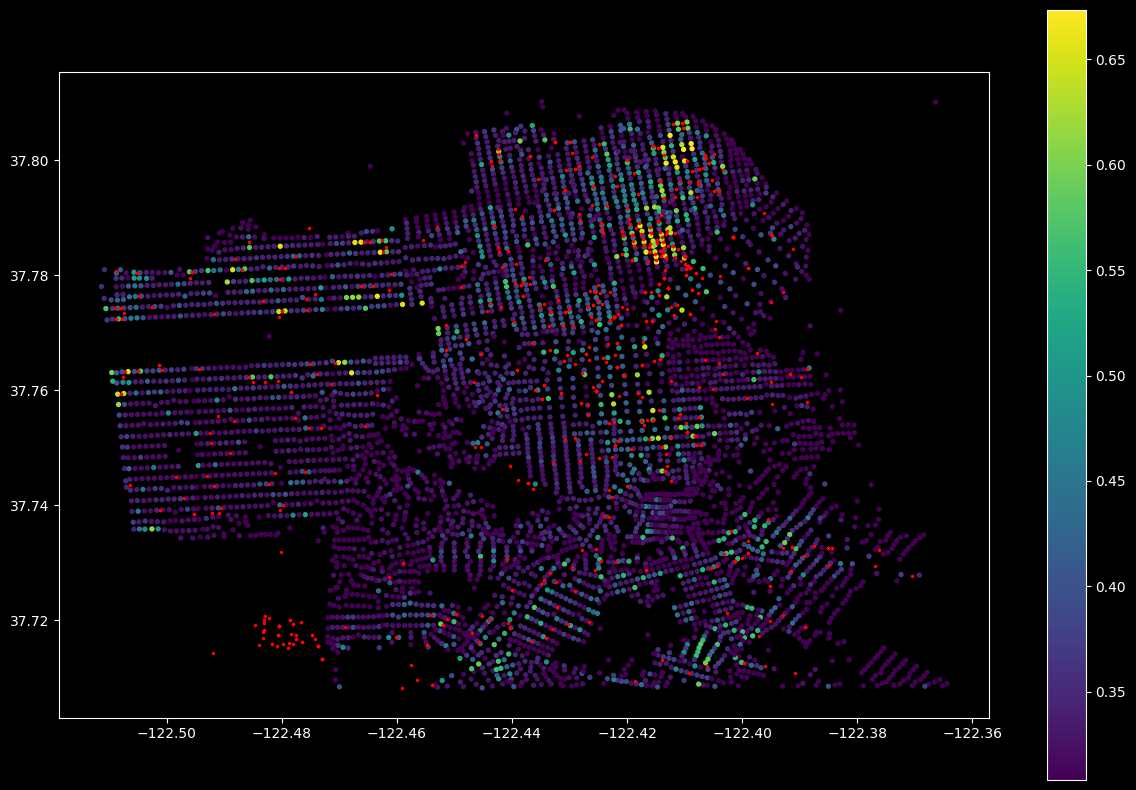

In [233]:
fig, ax = plt.subplots(figsize=(15, 10))
df_m.plot("y_pred", ax=ax, legend=True, markersize=8)
df_e.loc[df_e["year"] == 2020].plot(ax=ax, alpha=0.5, color="red", markersize=2)
plt.show()

,score,feature
24,3.0,cliques
14,4.0,use_code_misc
13,7.0,use_code_ind
11,8.0,use_code_como
9,14.0,use_code_comh
2,15.0,assessed_fixtures_value
18,17.0,degree
6,20.0,number_of_rooms
10,22.0,use_code_comm
12,25.0,use_code_comr


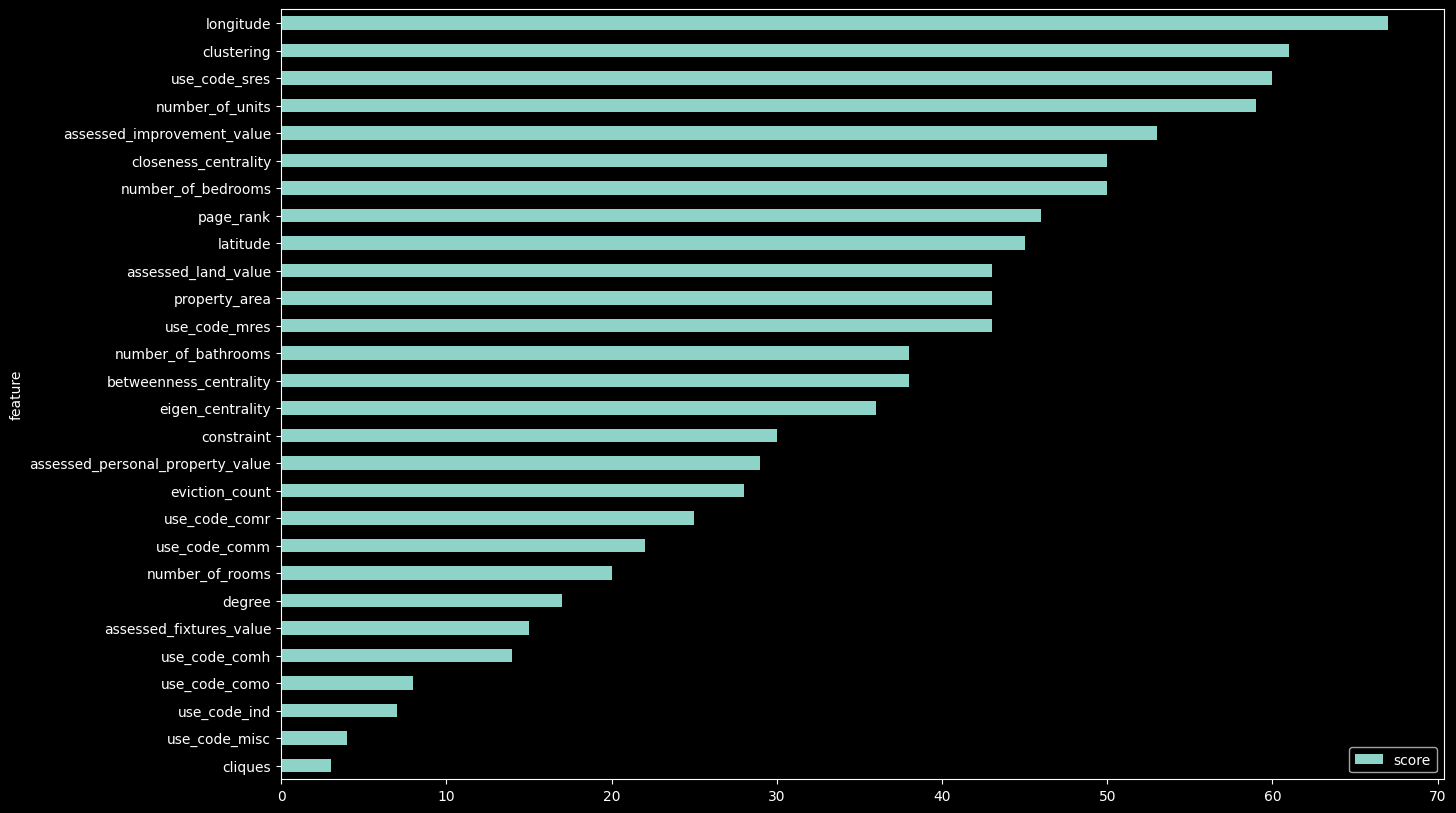

In [234]:
scores = model.get_score()
weights = model.get_score(importance_type="weight")
fi = pd.DataFrame([(scores[f"f{i}"], f) for i, f in enumerate(feature_sets["all"]) if f"f{i}" in scores], columns=["score", "feature"])
fi = fi.sort_values("score", ascending=True)
fi.plot.barh(figsize=(15, 10), x="feature", y="score")
fi